In [178]:
# PennyLane imports
import pennylane as qml
from pennylane import numpy as np

# General imports
import numpy as np
import re
import sympy as sp

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2, TwoLocal, RealAmplitudes
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize, differential_evolution, basinhopping

# Plotting functions
import matplotlib.pyplot as plt

# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=3)

In [179]:
def create_matrix(cut_off, type):
    # Initialize a zero matrix of the specified size
    matrix = np.zeros((cut_off, cut_off), dtype=np.complex128)
    
    # Fill the off-diagonal values with square roots of integers
    for i in range(cut_off):
        if i > 0:  # Fill left off-diagonal
            if type == 'q':
                matrix[i][i - 1] = (1/np.sqrt(2)) * np.sqrt(i)  # sqrt(i) for left off-diagonal
            else:
                matrix[i][i - 1] = (1j/np.sqrt(2)) * np.sqrt(i)

        if i < cut_off - 1:  # Fill right off-diagonal
            if type == 'q':
                matrix[i][i + 1] = (1/np.sqrt(2)) * np.sqrt(i + 1)  # sqrt(i + 1) for right off-diagonal
            else:
                matrix[i][i + 1] = (-1j/np.sqrt(2)) * np.sqrt(i + 1)

    return matrix

In [180]:
def convert_qiskit_pauli_string(s):
    # Find all characters followed by a number in brackets
    matches = re.findall(r'([A-Za-z])\((\d+)\)', s)

    # Sort the matches based on the order number (second element in tuple)
    sorted_matches = sorted(matches, key=lambda x: int(x[1]))

    # Join the characters in the sorted order
    return ''.join([char for char, _ in sorted_matches])

In [181]:
np.set_printoptions(precision=20)

In [267]:
cut_off = 16
q = create_matrix(cut_off, 'q')
p = create_matrix(cut_off, 'p')

Z = np.array([[1, 0], [0, -1]])  # Pauli Z matrix for fermion number
I_f = np.eye(2)  # Identity matrix for fermion space
I_b = np.eye(cut_off)

H_b = 0.5 *(np.matmul(q,q) + np.matmul(p,p))
H_b = np.kron(I_f, H_b)

H_f = 0.5*(np.kron(Z, I_b))
H = H_b + H_f
H[np.abs(H) < 10e-10] = 0

In [268]:
sympy_matrix = sp.Matrix(H)
sp.pprint(sympy_matrix, use_unicode=True)

⎡1.0   0    0    0    0    0    0    0    0    0     0     0     0     0     0 ↪
⎢                                                                              ↪
⎢ 0   2.0   0    0    0    0    0    0    0    0     0     0     0     0     0 ↪
⎢                                                                              ↪
⎢ 0    0   3.0   0    0    0    0    0    0    0     0     0     0     0     0 ↪
⎢                                                                              ↪
⎢ 0    0    0   4.0   0    0    0    0    0    0     0     0     0     0     0 ↪
⎢                                                                              ↪
⎢ 0    0    0    0   5.0   0    0    0    0    0     0     0     0     0     0 ↪
⎢                                                                              ↪
⎢ 0    0    0    0    0   6.0   0    0    0    0     0     0     0     0     0 ↪
⎢                                                                              ↪
⎢ 0    0    0    0    0    0

In [269]:
#pauli_decomposed = qml.pauli_decompose(H)
#coeffs = pauli_decomposed.coeffs

#paulis = []

#for x in pauli_decomposed.terms()[1]:
#    paulis.append(convert_qiskit_pauli_string(str(x)))

In [292]:
#hamiltonian = SparsePauliOp(paulis, coeffs=coeffs)
hamiltonian = SparsePauliOp.from_operator(H)
#hamiltonian = SparsePauliOp.from_list([('III',2), ('IIZ',0.5), ('IZI', -1), ('ZZI',-0.5)])
#ansatz = EfficientSU2(hamiltonian.num_qubits)
#ansatz = TwoLocal(hamiltonian.num_qubits, ['ry', 'rz'], 'cx', reps=3, entanglement='full')
ansatz = RealAmplitudes(num_qubits=hamiltonian.num_qubits, reps=1)
ansatz_isa = pm.run(ansatz)
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

In [293]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [294]:
num_params = ansatz.num_parameters
x0 = 2 * np.pi * np.random.random(num_params)

In [299]:
with Session(backend=aer_sim) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="COBYLA",
        tol='0.000000001'
    )


Iters. done: 620 [Current cost: 4.325700000000001]
Iters. done: 621 [Current cost: 4.5470999999999995]
Iters. done: 622 [Current cost: 3.3902000000000005]
Iters. done: 623 [Current cost: 2.8053000000000012]
Iters. done: 624 [Current cost: 6.4889]
Iters. done: 625 [Current cost: 4.027000000000001]
Iters. done: 626 [Current cost: 2.8049999999999997]
Iters. done: 627 [Current cost: 2.6201999999999996]
Iters. done: 628 [Current cost: 3.6132999999999997]
Iters. done: 629 [Current cost: 4.3903]
Iters. done: 630 [Current cost: 2.139099999999999]
Iters. done: 631 [Current cost: 2.6700000000000013]
Iters. done: 632 [Current cost: 1.9200000000000004]
Iters. done: 633 [Current cost: 4.234600000000002]
Iters. done: 634 [Current cost: 2.3866]
Iters. done: 635 [Current cost: 1.7957999999999996]
Iters. done: 636 [Current cost: 1.8628999999999996]
Iters. done: 637 [Current cost: 1.732999999999999]
Iters. done: 638 [Current cost: 1.5823999999999998]
Iters. done: 639 [Current cost: 2.0884000000000005]
I

In [252]:
minima = []

def callback(x, f, accept):
    info = [x,f,accept]
    minima.append(info)
    return

In [275]:
with Session(backend=aer_sim) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 10000
    #estimator.options.optimization_level = 1

    res = basinhopping(
        cost_func,
        x0,
        minimizer_kwargs={'method': "COBYLA",
                          "args": (ansatz_isa, hamiltonian_isa, estimator),
                          "options": {'maxiter':500}},
                          #"tol": '0.00001'},
        niter = 50,
        T = 0.25, #0.25
        callback=callback
    )

Iters. done: 215 [Current cost: 3.726500000000001]
Iters. done: 216 [Current cost: 3.5485999999999995]
Iters. done: 217 [Current cost: 4.101799999999998]
Iters. done: 218 [Current cost: 5.5707]
Iters. done: 219 [Current cost: 3.8566000000000003]
Iters. done: 220 [Current cost: 3.3209000000000013]
Iters. done: 221 [Current cost: 3.4688999999999997]
Iters. done: 222 [Current cost: 3.5413999999999994]
Iters. done: 223 [Current cost: 4.357399999999998]
Iters. done: 224 [Current cost: 5.757600000000001]
Iters. done: 225 [Current cost: 2.8348999999999993]
Iters. done: 226 [Current cost: 1.1054]
Iters. done: 227 [Current cost: 2.7173999999999987]
Iters. done: 228 [Current cost: 1.2508]
Iters. done: 229 [Current cost: 1.9849999999999994]
Iters. done: 230 [Current cost: 0.8437999999999998]
Iters. done: 231 [Current cost: 1.0469999999999995]
Iters. done: 232 [Current cost: 0.9052000000000002]
Iters. done: 233 [Current cost: 1.7158000000000007]
Iters. done: 234 [Current cost: 1.2964]
Iters. done:

In [298]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.22802734374999978
       x: [ 3.380e-01  2.441e+00  7.581e+00  1.595e+00  1.605e+00
            6.269e+00  4.206e+00  4.344e+00  4.745e+00  7.508e+00]
    nfev: 216
   maxcv: 0.0

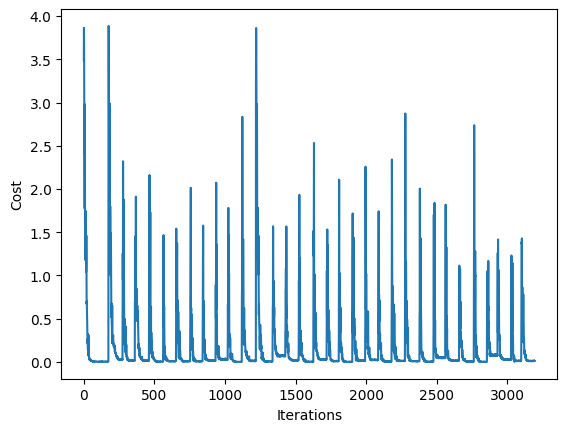

In [241]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()